### Sentinel-3数据处理
#### 1. geophysical correction.
#### 2. waveform retracking.


In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import netCDF4 as nc
import numpy as np
from pyrsimg import readTiff, imgShow, second_to_dyr


In [2]:
## s3 data
path_s3l2 = 'data/radar/S3A_SR_2_LAN____20230728T030708_20230728T035736_20230823T063435_3028_101_289______PS1_O_NT_004.SEN3/enhanced_measurement.nc'
## remote sensing data
path_rsimg = 'data/rsimg/s2_dianchi_20200511_wgs84_resam50m.tif'


In [3]:
## 1. s3l2 altimetry data
s3l2 = nc.Dataset(path_s3l2)    ##
## 2. remote sensing image
rsimg = readTiff(path_rsimg)


In [4]:
print('number of variables: ', len(s3l2.variables.keys()))
list(s3l2.variables.keys())


number of variables:  376


['time_01',
 'time_20_ku',
 'time_20_c',
 'echo_sample_ind',
 'UTC_day_01',
 'UTC_sec_01',
 'UTC_day_20_ku',
 'UTC_sec_20_ku',
 'UTC_day_20_c',
 'UTC_sec_20_c',
 'UTC_time_1hz_20_ku',
 'UTC_time_1hz_20_c',
 'lat_01',
 'lon_01',
 'lat_20_ku',
 'lon_20_ku',
 'lat_20_c',
 'lon_20_c',
 'lat_cor_20_ku',
 'lon_cor_20_ku',
 'lat_cor_20_c',
 'lon_cor_20_c',
 'surf_type_01',
 'surf_type_20_ku',
 'surf_type_20_c',
 'surf_class_01',
 'surf_class_20_ku',
 'surf_class_20_c',
 'rad_surf_type_01',
 'angle_coast_01',
 'angle_coast_20_ku',
 'angle_coast_20_c',
 'dist_coast_01',
 'dist_coast_20_ku',
 'dist_coast_20_c',
 'alt_01',
 'alt_20_ku',
 'alt_20_c',
 'orb_alt_rate_01',
 'orb_alt_rate_20_ku',
 'orb_alt_rate_20_c',
 'tracker_range_20_ku',
 'tracker_range_20_c',
 'tracker_range_20_plrm_ku',
 'h0_nav_dem_20_ku',
 'agc_01_ku',
 'agc_01_c',
 'agc_01_plrm_ku',
 'agc_20_ku',
 'agc_20_c',
 'agc_20_plrm_ku',
 'agc_numval_01_ku',
 'agc_numval_01_c',
 'agc_numval_01_plrm_ku',
 'agc_rms_01_ku',
 'agc_rms_01_c

In [5]:
lat_20_ku = s3l2['lat_cor_20_ku'][:]
lon_20_ku = s3l2['lon_cor_20_ku'][:]
time_20_ku = s3l2['time_20_ku'][:]
time_20_ku = second_to_dyr(time_20_ku)   ## seconds to year.


Text(0.5, 1.0, 'sentinel-3 altimetry data')

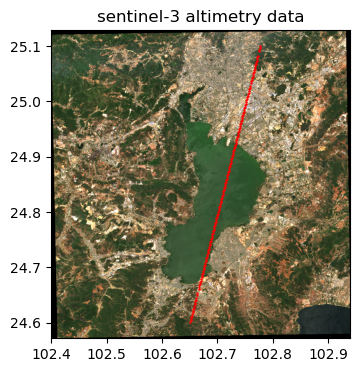

In [6]:
ids_1 = np.where((lat_20_ku[:]>24.6) & (lat_20_ku[:]<25.1))
fig = plt.figure(figsize=(4, 4))
ax = plt.subplot(1,1,1)
imgShow(rsimg.array, extent=rsimg.geoextent, ax=ax)
plt.scatter(x=lon_20_ku[ids_1], y=lat_20_ku[ids_1], s=0.5, color='red')  ## altimetry data
plt.title('sentinel-3 altimetry data')


#### 1. 地球物理改正：干对流层改正，湿对流层改正，电离层改正，负荷潮改正，固体地球改正，极潮改正。

In [7]:
## 1. geophysical correction by refering to official document.
geo_corr_01hz=['mod_dry_tropo_cor_meas_altitude_01',
        'mod_wet_tropo_cor_meas_altitude_01',
        'iono_cor_gim_01_ku',
        'load_tide_sol1_01',
        'solid_earth_tide_01',
        'pole_tide_01']
corr_01hz = 0
for cor_01hz_name in geo_corr_01hz:
  corr_01hz += s3l2[cor_01hz_name][:]
print(corr_01hz.shape)
print(corr_01hz)


(2019,)
[-2.4925 -2.4914 -2.4904 ... -1.641  -1.6463 -1.6534]


In [8]:
def hz01_hz20(data_01hz, time_01hz, time_20hz):
    '''
    des: convert 01hz data to 20hz data through time nearest interpolation.
    '''
    time_20hz_ = np.expand_dims(time_20hz, axis=1)
    dif_time = abs(time_20hz_ - time_01hz)
    ind_min = dif_time.argmin(axis=1)
    data_20hz = data_01hz[ind_min]
    return data_20hz


In [9]:
## 2. Resample the 1Hz variables to 20Hz variables
times_20 = s3l2['time_20_ku'][:]
times_01 = s3l2['time_01'][:]
corr_20hz = hz01_hz20(data_01hz=corr_01hz, time_01hz=times_01, time_20hz=times_20)
print(corr_20hz.shape)


(40427,)


In [10]:
## 3. Calculate the corrected surface water height
## 3.1 ocean retracker without correction.
h_ocean = s3l2['alt_20_ku'][:] - s3l2['range_ocean_20_ku'][:]
h_ocean = h_ocean.filled(np.nan)
## 3.1 ocean retracker with geophysical correction
h_ocean_cor = s3l2['alt_20_ku'][:] - s3l2['range_ocean_20_ku'][:] - corr_20hz
h_ocean_cor = h_ocean_cor.filled(np.nan)


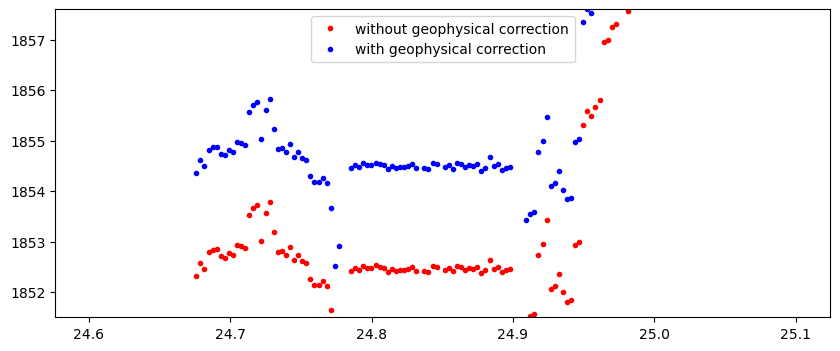

In [11]:
### compare the geophysical-corrected elevations with the no geophysical-corrected elevation
plt.figure(figsize=(10,4))
plt.plot(lat_20_ku[ids_1], h_ocean[ids_1], 'r.', label='without geophysical correction')
plt.plot(lat_20_ku[ids_1], h_ocean_cor[ids_1], 'b.', label='with geophysical correction')
plt.ylim(1851.5, 1857.6)
plt.legend()


(1851.5, 1857.6)

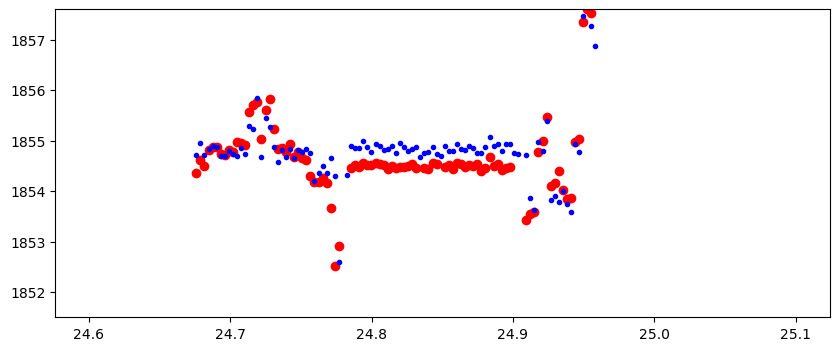

In [12]:
### compare the geophysical-corrected elevation with the official provided elevation.
## ocean vs. ocog (官方未提供ocean重追踪改正后地表高度数据)
h_ocog_official = s3l2['elevation_ocog_20_ku'][:]
## ocog retracker with geophysical correction
h_ocog_cor = s3l2['alt_20_ku'][:] - (s3l2['range_ocog_20_ku'][:] + corr_20hz)
h_ocog_cor = h_ocog_cor.filled(np.nan)

plt.figure(figsize=(10,4))
# plt.plot(lat_20_ku[ids_1], h_ocog_cor[ids_1], 'ro')
plt.plot(lat_20_ku[ids_1], h_ocean_cor[ids_1], 'ro')
plt.plot(lat_20_ku[ids_1], h_ocog_official[ids_1], 'b.')
# plt.ylim(1854., 1855.6)
plt.ylim(1851.5, 1857.6)


### <font color='brown'>**2. Atimeter range correction with waveform retracking.**</font>
#### Nominal tracking point: gate 43
#### The distance bettween two gates is 3.125 ns * 0.3 m/ns = 0.9375 m


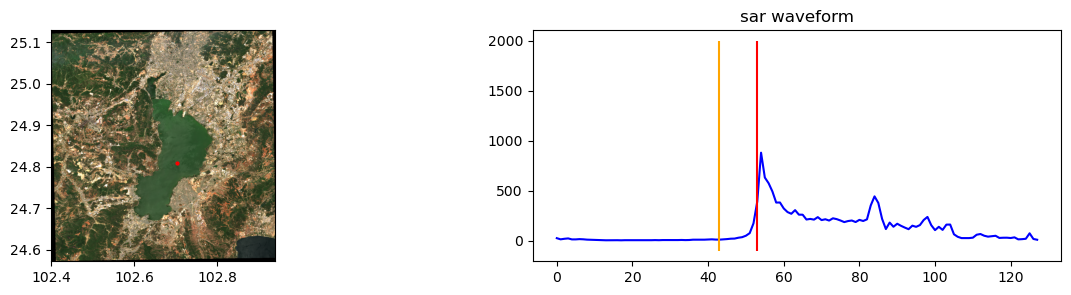

In [ ]:
ids_2 = np.where((lat_20_ku[:]>24.8) & (lat_20_ku[:]<24.81))[0]  ### the range of dianchi
# ids = np.argmin(abs((lat_20_ku[:] - 24.8)))
id = ids_2[0]
wf_sar = s3l2['waveform_20_ku'][:][id]
fig, ax = plt.subplots(1,2, figsize=(15,3))
imgShow(rsimg.array, extent=rsimg.geoextent, ax=ax[0])
ax[0].scatter(x=lon_20_ku[id], y=lat_20_ku[id], s=4, color='red')  ## altimetry data
ax[1].plot(s3l2['echo_sample_ind'][:], wf_sar, color='blue')
ax[1].set_title('sar waveform')
gate_nominal = 43
ax[1].vlines(gate_nominal, ymin=-100, ymax=2000, color='orange')   ## nominal gate
gate_retrack = 53
ax[1].vlines(gate_retrack, ymin=-100, ymax=2000, color='red')   ## retracked gate


In [14]:
### 1. the official provided elevation (geophysical correction + waveform retracker)
print('retracked elevation provided by official:',s3l2['elevation_ocog_20_ku'][id])

### 2. Elevation without waveform retracking
h_cor = s3l2['alt_20_ku'][id] \
            - (s3l2['tracker_range_20_ku'][id])\
            - corr_20hz[id]
print('elevation without waveform retracking:', h_cor)

### 3. The elevation with the geophyiscal correction and the retraked altimeter range.
cor_retrack = (gate_retrack-gate_nominal)*3.125*0.3/2  ## 3.125 ns is the time duration bettween neighboring gates , 0.3 is the light speed, 0.3 m/ns.
# cor_retrack = (gate_retrack-nominal_gate)*0.46875
print('retracker correction:', cor_retrack)
h_cor_retracked = s3l2['alt_20_ku'][id] \
                      - (s3l2['tracker_range_20_ku'][id]+cor_retrack)\
                      - corr_20hz[id]
print('elevation with manually geophysical and retracker correction:', h_cor_retracked)    ## error



retracked elevation provided by official: 1854.8054000000002
elevation without waveform retracking: 1860.0611000000672
retracker correction: 4.6875
elevation with manually geophysical and retracker correction: 1855.3736000000672
